In [61]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA


##Data Augmentation
- Dia das mães
- Nome da loja
- Feriado

##Algoritmos
- ANN
- XGBoost
- TSAI
- SARIMA



- entrega dia 17/11
- csv com as predicoes
- codigo
- relatorio
    - arquitetura da solução
    - medidas de avaliacao
    - achados e dificuldades
    - licoes aprendidas

In [40]:
def split_data(df):
  web = df[df['tipo_loja'] == 'web']
  fisica = df[df['tipo_loja'] == 'física']

  return fisica, web

def adjust_data(df):
  df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%dT%H:%M:%S.%fZ')
  df = df.pivot(index='ds', columns='loja', values='venda').fillna(0).rename_axis(None, axis=1)

  return df

def scale_data(df):
  for c in df.columns:
    df[c] = MinMaxScaler().fit_transform(df[c].values.reshape(-1, 1)).reshape(1, -1)[0]

  return df


In [41]:
class TSData:
    def __init__(self, column, df):
        self.name = column
        self.data = df[[column]]
        self.data[column + '_scaled'] = self.__scale_data()
        self.features = self.create_features()

    def __str__(self):
        return f'{self.name} - data:{self.data.shape} - features:{self.features.shape}'

    def __scale_data(self):
        scaler = MinMaxScaler()
        data = scaler.fit_transform(self.data[self.name].values.reshape(-1,1))
        return data.reshape(1, -1)[0]

    def create_features(self):
        features = pd.DataFrame()
        
        features['MA_3'] = self.data[self.name].rolling(3).mean()
        features['MA_7'] = self.data[self.name].rolling(7).mean()
        features['MA_14'] = self.data[self.name].rolling(14).mean()
        features['MA_21'] = self.data[self.name].rolling(21).mean()

        features['STD_3'] = self.data[self.name].rolling(3).std()
        features['STD_7'] = self.data[self.name].rolling(7).std()
        features['STD_14'] = self.data[self.name].rolling(14).std()
        features['STD_21'] = self.data[self.name].rolling(21).std()

        return features.fillna(0)

In [42]:
#test_file = '/content/drive/MyDrive/PUC/Ciência de Dados e Inteligência Artificial/2022-02/98H05-04 - Aprendizado Supervisionado/TF/data/renner_sales_sample_test.csv'
#train_file = '/content/drive/MyDrive/PUC/Ciência de Dados e Inteligência Artificial/2022-02/98H05-04 - Aprendizado Supervisionado/TF/data/renner_sales_sample_train.csv'

test_file = '../TF/data/renner_sales_sample_test.csv'
train_file = '../TF/data/renner_sales_sample_train.csv'

test = pd.read_csv(test_file)
train = pd.read_csv(train_file)

test = adjust_data(test)
train = adjust_data(train)

train_scaled = scale_data(train.copy(deep=True))
test_scaled = scale_data(test.copy(deep=True))

In [ ]:
for k in dataDict.keys():
    fig = sm.tsa.seasonal_decompose(dataDict[k].data[k]).plot()
    fig.set_figheight(8)
    fig.set_figwidth(15)
    fig.savefig(f'plot/decompose_{k}.png')
    plt.close(fig)

In [ ]:
sns.heatmap(data.iloc[236:243].corr())

In [ ]:
sns.scatterplot(data.iloc[210])

In [49]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [ ]:
#tenta prever a venda de uma loja específica criando estimativas para cada semana
#as estimativas devem ser classificadas conforme o range de vendas da loja
#pex:
#range 1: 0-10
#range 2: 10-20
#range 3: 20-30
#e assim por diante
#desse modo o classificador pode ser treinado para prever o range de vendas da loja
#utilizar indicadores de tendência e sazonalidade para estimar o range de vendas
#utilizar o modelo de regressão linear para estimar o range de vendas
#utilizar o modelo de regressão logística para estimar o range de vendas
#utilizar indicadores financeiros para estimar o range de vendas, como por exemplo, 
# média móvel, média ponderada, média exponencial, bandas de bollinger e etc



In [55]:
#https://machinelearningmastery.com/xgboost-for-time-series-forecasting/
#X = train_scaled['renner_ar_ex_1'].values
#y = train_scaled['renner_ar_ex_1'].shift(1).values
train_data = series_to_supervised(train_scaled[['renner_ar_ex_1']])
test_data = series_to_supervised(test_scaled[['renner_ar_ex_1']])

X = train_data[:, :-1]
y = train_data[:, -1]

X_test = test_data[:, :-1]
y_test = test_data[:, -1]

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X, y)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

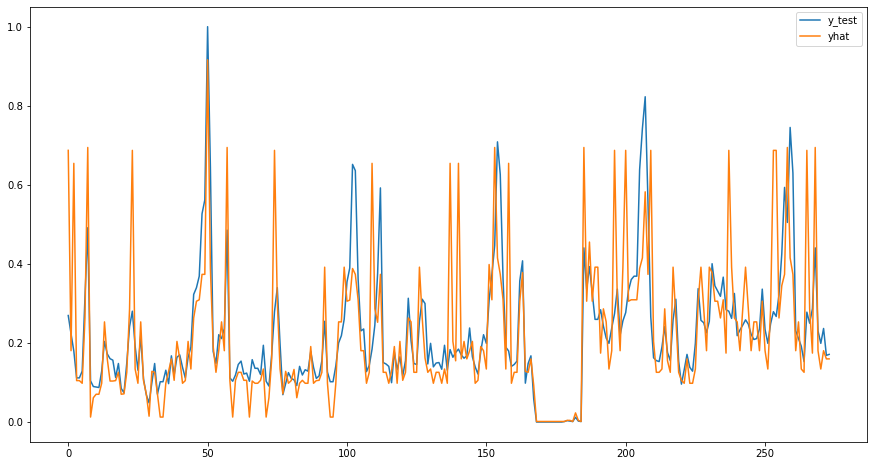

In [93]:

test_data = series_to_supervised(train_scaled[['renner_br_al_25']])
X_test = test_data[:, :-1]

row = X_test[:].flatten()
# make a one-step prediction
yhat = model.predict(np.asarray(row))
#print(f'Input: {row}, Predicted: {yhat}')

#plot results
fig = plt.figure(figsize=(15,8))
plt.plot(X_test, label='y_test')
plt.plot(yhat, label='yhat')
plt.legend()
plt.show()

In [92]:
train_scaled

,renner_ar_ex_1,renner_ar_ex_2,renner_ar_ex_3,renner_ar_ex_4,renner_br_ac_1,renner_br_al_21,renner_br_al_25,renner_br_al_34,renner_br_al_60,renner_br_am_1,...,renner_br_to_11,renner_uy_ex_1,renner_uy_ex_2,renner_uy_ex_3,renner_uy_ex_4,renner_uy_ex_5,renner_uy_ex_6,renner_uy_ex_7,renner_uy_ex_8,renner_uy_ex_9
ds,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.000000,0.000000,0.000000,0.000000,0.398760,0.515654,0.269417,0.184486,0.407080,0.387578,...,0.275492,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-08,0.000000,0.000000,0.000000,0.000000,0.326446,0.372007,0.223301,0.238994,0.294690,0.257143,...,0.257603,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-15,0.000000,0.000000,0.000000,0.000000,0.219008,0.401473,0.179612,0.218029,0.271681,0.255901,...,0.168157,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-22,0.000000,0.000000,0.000000,0.000000,0.194215,0.254144,0.111650,0.167715,0.213274,0.345342,...,0.130590,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-29,0.000000,0.000000,0.000000,0.000000,0.250000,0.270718,0.111650,0.180294,0.201770,0.526708,...,0.114490,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-06,0.042553,0.057416,0.058824,0.043568,0.330579,0.342541,0.199029,0.264151,0.278761,0.198758,...,0.314848,0.022951,0.031187,0.013959,0.0,0.008108,0.009424,0.005666,0.016282,0.015437
2022-03-13,0.037234,0.064593,0.025735,0.045643,0.367769,0.331492,0.236650,0.278826,0.234513,0.228571,...,0.314848,0.017213,0.024145,0.012056,0.0,0.008108,0.014660,0.002833,0.009498,0.010292
2022-03-20,0.021277,0.016746,0.011029,0.006224,0.299587,0.246777,0.168689,0.293501,0.220354,0.187578,...,0.194991,0.013115,0.009054,0.003807,0.0,0.006306,0.004188,0.000000,0.004071,0.011149


In [46]:
train_scaled['renner_ar_ex_3'].values

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
train.plot(legend=False, figsize=(15,8))

In [ ]:
data = train.copy(deep=True)
data.set_index('ds', inplace=True)
data[(data['tipo_loja'] == 'física') & (data['loja'] == 'renner_ar_ex_1')][['venda']].plot()

In [ ]:
train.groupby(by='loja').sum()

In [ ]:
train.pivot(index='ds', columns='loja', values='venda').fillna(0)

In [ ]:
temp = adjust_data(train)
temp

In [ ]:
column = 'renner_ar_ex_1'
tsData = TSData(column, temp)
tsData.features


In [ ]:
print(tsData)

In [ ]:
javascript:__doPostBack('ViewerControl1$TreeViewFiles','sR28324\\F2222850')

In [ ]:
temp = adjust_data(test)

scaler = MinMaxScaler()
data = scaler.fit_transform(temp['renner_br_rj_81'].values.reshape(-1,1))
data.reshape(1, -1)[0]

In [ ]:
temp[['renner_br_rj_81']].rolling(21).mean()

In [ ]:
temp = adjust_data(train)
temp['renner_br_rj_81']

tsData = TSData('renner_br_rj_81', temp)

In [ ]:
tsData.create_features(temp, 'renner_br_rj_81')

In [ ]:
#construir rede neural que recebe como entrada o conjunto de k dias anteriores e retorna o valor previsto para o dia seguinte
def build_model():
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    return model

In [ ]:
############################################################################################################

In [ ]:
temp = adjust_data(test)
#transform_data(temp, 'renner_ar_ex_2')
#temp = test.pivot(index='ds', columns='loja', values='venda').fillna(0).rename_axis(None, axis=1)

In [ ]:
fisica, web = split_data(train)

In [ ]:
web['loja'].unique()

In [ ]:
train[train['loja'].isin(['renner_br_sp_192', 'renner_br_rj_81'])]['tipo_loja'].unique()

In [ ]:
############################################################################################################

In [ ]:
temp = test.pivot(index='ds', columns='loja', values='venda').fillna(0)
temp


column = 'renner_br_ac_1'
temp[[column]]